<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Pairs Trading](Introduction.ipynb) › Part 3: Pairs Selection Pipeline
***

# Pairs Selection Pipeline

The previous notebook showed deteriorating performance in the example pair GLD-GDX over time. In this notebook we aim to mitigate the problem of deteriorating performance by exploring a more dynamic approach to identifying and selecting pairs.

We follow a 4-step process:

1. Filter the universe of ETFs to those meeting our dollar volume requirements
2. Run the Johansen test on all possible pairs to identify cointegrating pairs in-sample
3. Run in-sample backtests on all cointegrating pairs to find the best performing pairs
4. Select the 5 best performing pairs for an out-of-sample backtest

## Variables

Setting the following variables appropriately will allow the remainder of the notebook to be adapted to different universes, liquidity filters, or date ranges.

In [1]:
DB = "usstock-1d"
UNIVERSE = "us-etf"
MIN_DOLLAR_VOLUME = 80e6 # $80M USD
COINTEGRATION_CONFIDENCE_LEVEL = 90 # require cointegration at 90%, 95%, or 99% confidence 
COINTEGRATION_START_DATE = "2011-01-01" # conintegration test starts here...
COINTEGRATION_END_DATE = "2013-12-31" # ...and ends here
IN_SAMPLE_END_DATE = "2016-12-31" # in-sample backtest starts at the cointegration end date and ends here

## Step 1: Filter by dollar volume

First we filter the universe of ETFs to include only securities having average dollar volume of at least $80M USD in the in-sample period.

In [2]:
from quantrocket import get_prices
prices = get_prices(DB, universes=UNIVERSE, start_date=COINTEGRATION_START_DATE, end_date=COINTEGRATION_END_DATE, fields=["Close", "Volume"])
closes = prices.loc["Close"]
volumes = prices.loc["Volume"]
dollar_volumes = (closes * volumes).mean()
adequate_dollar_volumes = dollar_volumes[dollar_volumes >= MIN_DOLLAR_VOLUME]

print(f"{len(adequate_dollar_volumes.index)} of {len(closes.columns)} have dollar volume > {MIN_DOLLAR_VOLUME}")

75 of 1888 have dollar volume > 80000000.0


## Step 2: Find Cointegrating Pairs

Next, we combine the liquid ETFs into all possible pairs:

In [3]:
import itertools
all_pairs = list(itertools.combinations(adequate_dollar_volumes.index, 2))

print(f"formed {len(all_pairs)} total pairs")

formed 2775 total pairs


Then we use the `coint_johansen` function from the `statsmodels` library to identify pairs that cointegrate with at least 95% confidence:

> In the `get_hedge_ratio` method in the Moonshot strategy, we used the Johansen test to obtain hedge ratios but ignored the test statistics and critical values (i.e. we don't actually test for cointegration in the pairs backtest itself). Here, we do the opposite: we don't need the hedge ratios but rather check the test statistics against the critical values to determine if there is cointegration. 

In [4]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
from IPython.display import clear_output

cointegrating_pairs = []

for i, (sid_1, sid_2) in enumerate(all_pairs): 
    
    # Display progress
    clear_output(wait=True)
    print(f"Running Johansen test on pair {i} of {len(all_pairs)}")
    
    pair_closes = closes[[sid_1, sid_2]].dropna()
    
    # Skip pairs with less than 90 non-null obversations
    if len(pair_closes) < 90:
        continue
        
    # The second and third parameters indicate constant term, with a lag of 1. 
    # See Chan, Algorithmic Trading, chapter 2.
    result = coint_johansen(pair_closes, 0, 1)
    
    # the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
    # eigenvalue statistic are stored in the first, second, and third column of 
    # cvt and cvm, respectively
    confidence_level_cols = {
        90: 0,
        95: 1,
        99: 2
    }
    confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]
    
    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    
    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        
        cointegrating_pairs.append(dict(
            sid_1=sid_1,
            sid_2=sid_2
        ))
        
clear_output()

We find the following number of cointegrating pairs:

In [5]:
len(cointegrating_pairs)

62

## Step 3: Run In-Sample Backtests on All Cointegrating Pairs

Having identified all cointegrating pairs, the next step is to run an in-sample backtest on each cointegrating pair. The in-sample backtest period is subsequent to the cointegration test period, but we still consider it in-sample because we will use the performance results from the in-sample backtests to select a portfolio of pairs for out-of-sample testing.

First, we download symbols and names from the securities master database to help us know what we're testing:

In [6]:
from quantrocket.master import download_master_file
import io
import pandas as pd

f = io.StringIO()
download_master_file(f, sids=list(dollar_volumes.index), fields=["Symbol","Name"])
securities = pd.read_csv(f, index_col="Sid")

# Convert to dict of {<sid>: {Symbol: <symbol>, Name: <name>}}
securities = securities.to_dict(orient="index")

To run backtests on so many pairs, we take advantage of Moonshot's ability to set strategy parameters dynamically using the `params` argument. We use Moonchart to calculate the Sharpe ratios of each pair strategy:

In [7]:
from quantrocket.moonshot import backtest
from moonchart import DailyPerformance

all_results = []
for i, pair in enumerate(cointegrating_pairs):
    
    sid_1 = pair["sid_1"]
    sid_2 = pair["sid_2"]
    
    security_1 = securities[sid_1]
    security_2 = securities[sid_2]
    
    symbol_1 = security_1["Symbol"]
    symbol_2 = security_2["Symbol"]
    
    name_1 = security_1["Name"]
    name_2 = security_2["Name"]
       
    # Display progress
    clear_output(wait=True)
    print(f"Backtesting pair {i+1} of {len(cointegrating_pairs)}: {symbol_1}/{symbol_2} ({name_1} and {name_2})")
        
    f = io.StringIO()
    
    # Run backtest
    backtest("pairs", start_date=COINTEGRATION_END_DATE, 
             end_date=IN_SAMPLE_END_DATE,
             params={
                 "DB": DB,
                 "SIDS": [sid_1, sid_2]}, 
             filepath_or_buffer=f)
    
    # Get Sharpe and CAGR
    perf = DailyPerformance.from_moonshot_csv(f)
    sharpe = perf.sharpe.iloc[0]
    cagr = perf.cagr.iloc[0]
    
    all_results.append({
        "sid_1": sid_1,
        "sid_2": sid_2,
        "symbol_1": symbol_1,
        "symbol_2": symbol_2,
        "name_1": name_1,
        "name_2": name_2,
        "sharpe": sharpe,
        "cagr": cagr,
    })

clear_output()
results = pd.DataFrame(all_results)

We sort by Sharpe ratio, and show the best 5 performers:

In [8]:
results = results.sort_values("sharpe", ascending=False)
best_pairs = results.head(5)
best_pairs

,sid_1,sid_2,symbol_1,symbol_2,name_1,name_2,sharpe,cagr
43,FIBBG000HT88C8,FIBBG000JLF4M3,VWO,TZA,VANGUARD FTSE EMERGING MARKE,DIREXION DLY SM CAP BEAR 3X,1.250892,0.262755
27,FIBBG000F7KQG0,FIBBG000FBND22,AGQ,TBT,PROSHARES ULTRA SILVER,PROSHARES ULTRASHORT 20+Y TR,0.913857,0.215929
10,FIBBG000BJKYW3,FIBBG000D02J82,TLT,OIH,ISHARES 20+ YEAR TREASURY BO,VANECK OIL SERVICES,0.883691,0.112128
16,FIBBG000CDKWX8,FIBBG000JLF4M3,EWY,TZA,ISHARES MSCI SOUTH KOREA ETF,DIREXION DLY SM CAP BEAR 3X,0.876118,0.164784
6,FIBBG000BHR296,FIBBG000HDFTG5,IEF,FXE,ISHARES 7-10 YEAR TREASURY B,INVESCO CURRENCYSHARES EURO,0.671811,0.028925


## Step 4: Out-of-sample Backtest

Having found the 5 best performing pairs, we create a Moonshot strategy for each pair and run an out-of-sample backtest on the portfolio of pairs.

In order to avoid lots of typing, we use the code below to print out the Moonshot subclasses, which we can then copy and paste into `pairs.py`:

In [9]:
# Save the strategy codes to use in the subsequent backtest
best_pairs_codes = []

# Print the subclass definitions
for i, pair in best_pairs.iterrows():
    
    strategy_code = f"pair-{pair.symbol_1.lower()}-{pair.symbol_2.lower()}"
    
    subclass_code = f"""
class {pair.symbol_1}_{pair.symbol_2}_Pair(PairsStrategy):
    
    CODE = "{strategy_code}"
    DB = "{DB}"
    SIDS = [
        "{pair.sid_1}", # {pair.symbol_1}
        "{pair.sid_2}" # {pair.symbol_2}
    ]""" 
    print(subclass_code)
    best_pairs_codes.append(strategy_code)



class VWO_TZA_Pair(PairsStrategy):
    
    CODE = "pair-vwo-tza"
    DB = "usstock-1d"
    SIDS = [
        "FIBBG000HT88C8", # VWO
        "FIBBG000JLF4M3" # TZA
    ]

class AGQ_TBT_Pair(PairsStrategy):
    
    CODE = "pair-agq-tbt"
    DB = "usstock-1d"
    SIDS = [
        "FIBBG000F7KQG0", # AGQ
        "FIBBG000FBND22" # TBT
    ]

class TLT_OIH_Pair(PairsStrategy):
    
    CODE = "pair-tlt-oih"
    DB = "usstock-1d"
    SIDS = [
        "FIBBG000BJKYW3", # TLT
        "FIBBG000D02J82" # OIH
    ]

class EWY_TZA_Pair(PairsStrategy):
    
    CODE = "pair-ewy-tza"
    DB = "usstock-1d"
    SIDS = [
        "FIBBG000CDKWX8", # EWY
        "FIBBG000JLF4M3" # TZA
    ]

class IEF_FXE_Pair(PairsStrategy):
    
    CODE = "pair-ief-fxe"
    DB = "usstock-1d"
    SIDS = [
        "FIBBG000BHR296", # IEF
        "FIBBG000HDFTG5" # FXE
    ]


Having copied the above code into `pairs.py`, we are ready to run the out-of-sample backtest:

In [10]:
backtest(best_pairs_codes, start_date=IN_SAMPLE_END_DATE, end_date="2019-12-31", filepath_or_buffer="best_pairs_results.csv")

The tear sheet shows good performance in the first year and a half out of sample followed by deteriorating performance, perhaps indicating that we need to re-run cointegration tests and in-sample backtests on a forward basis and update our portfolio of best pairs every year or two.

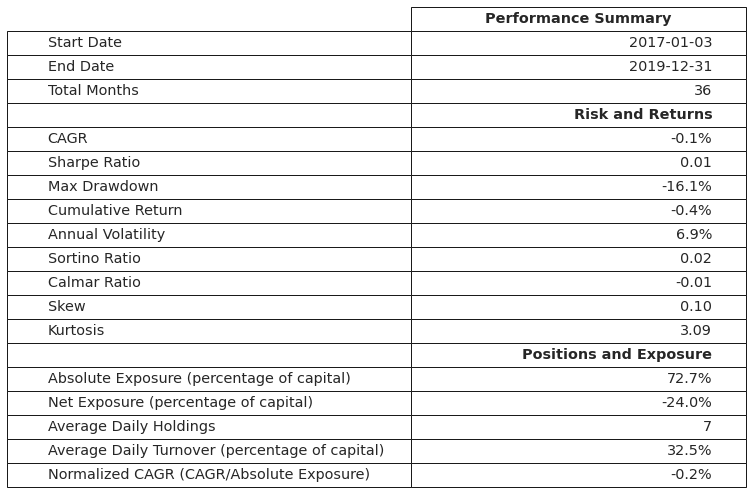

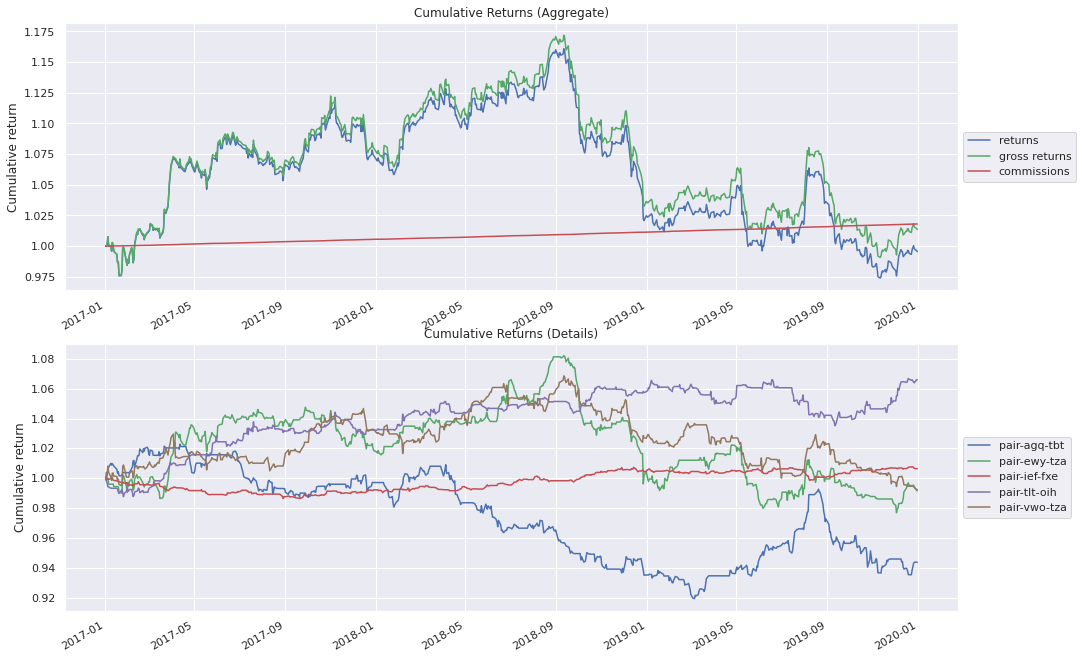

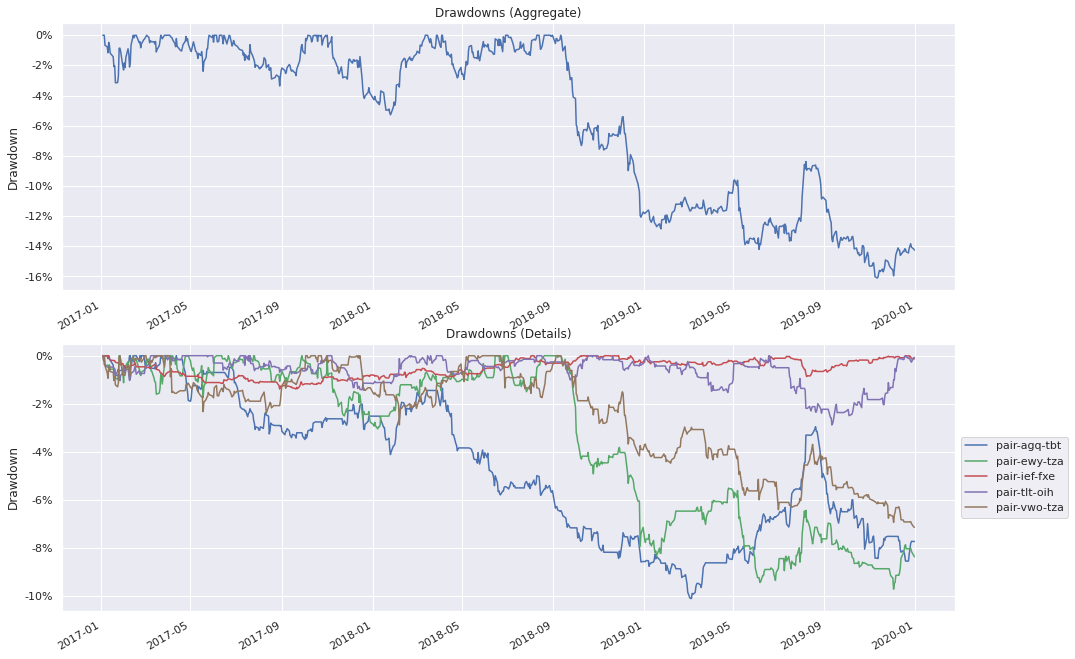

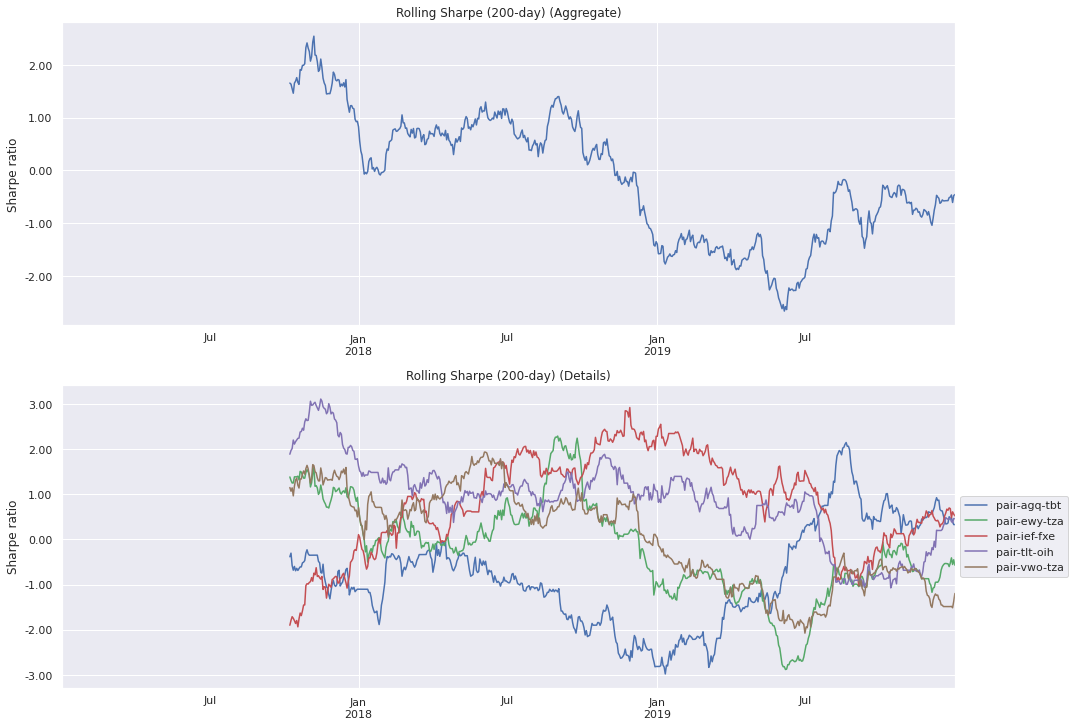

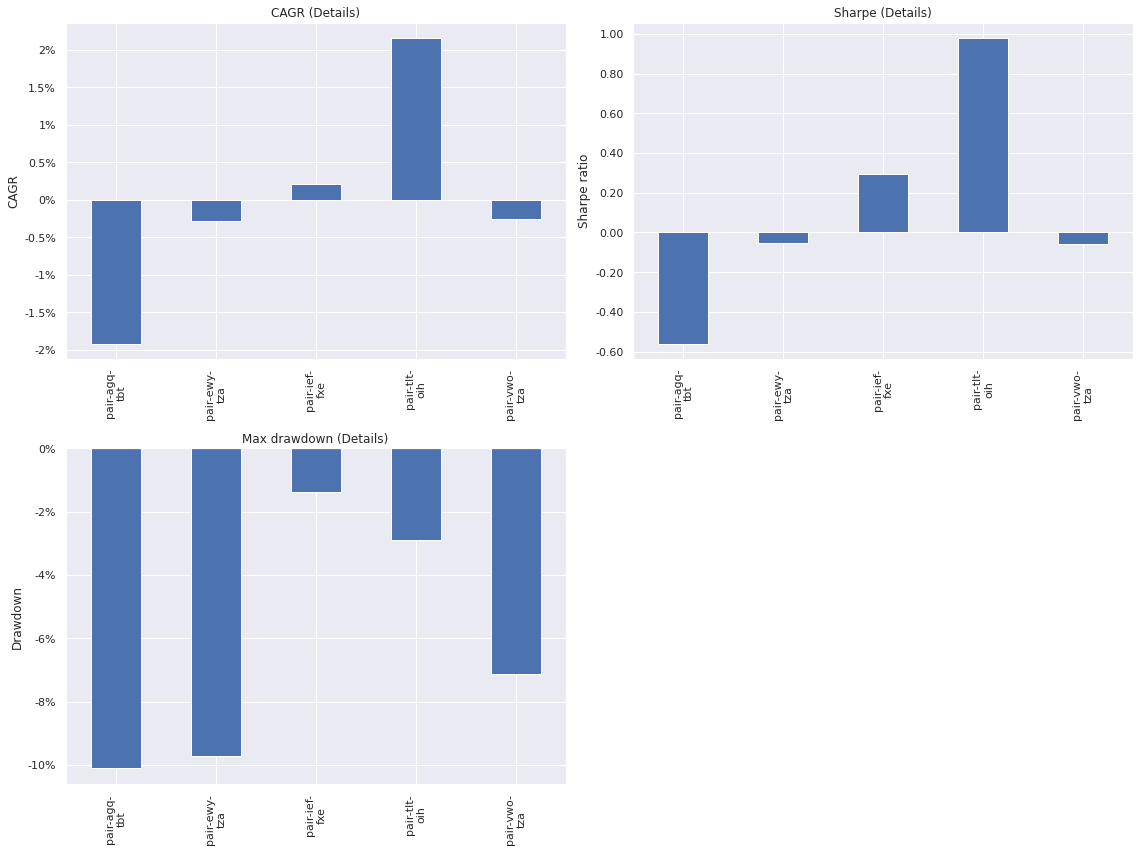

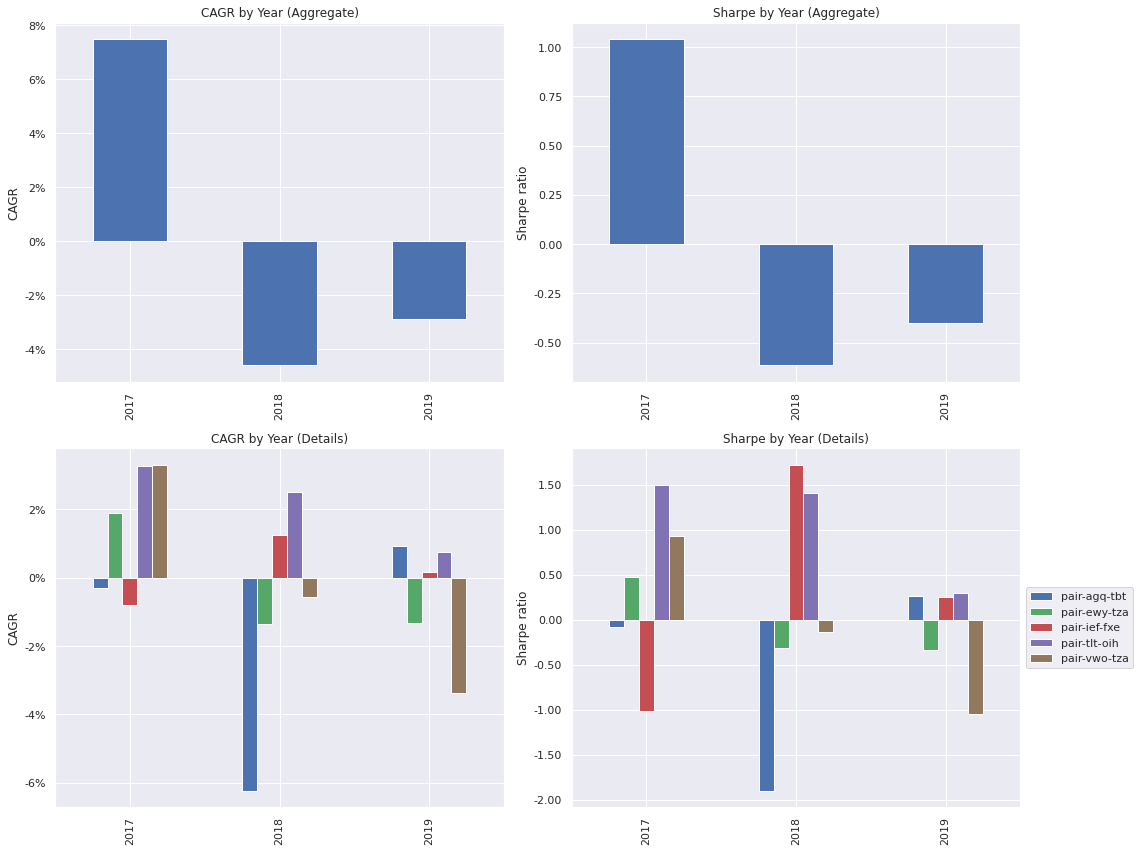

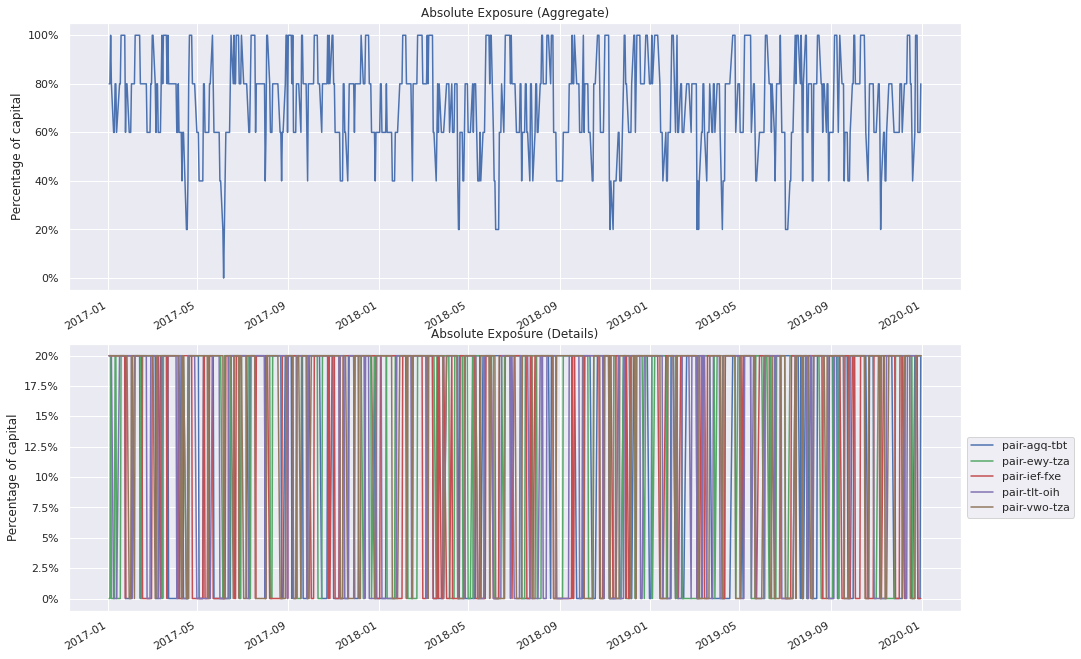

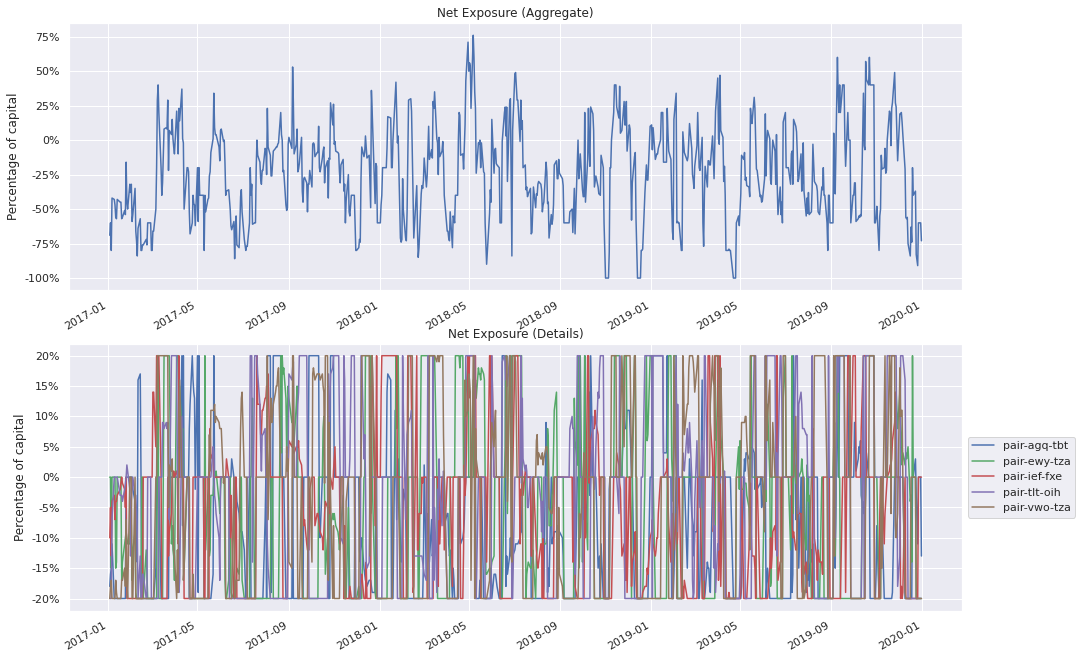

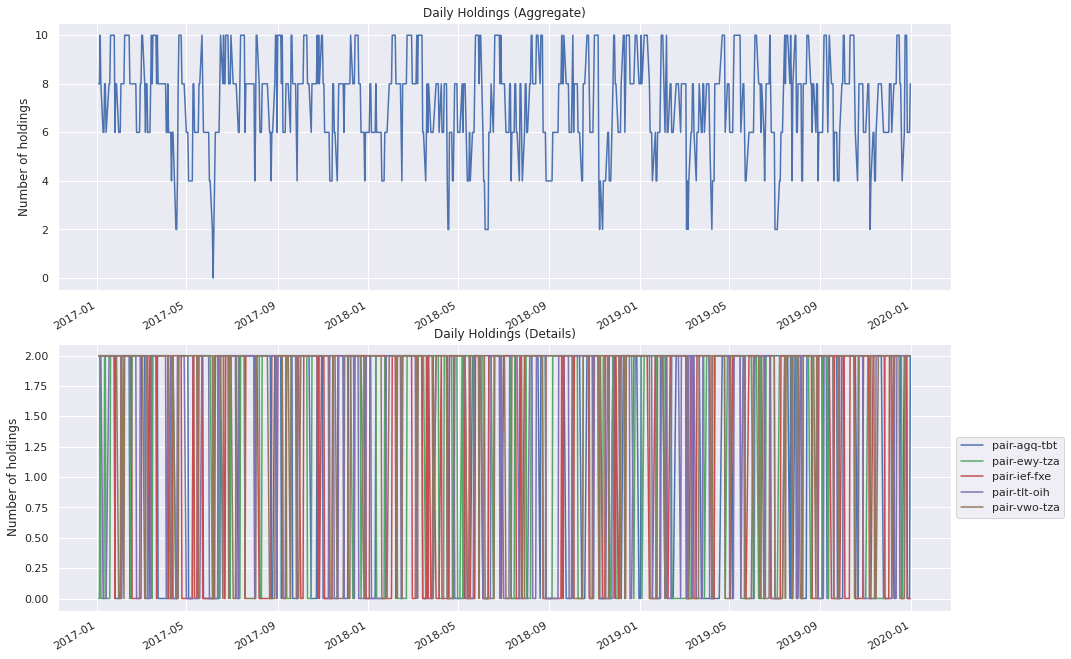

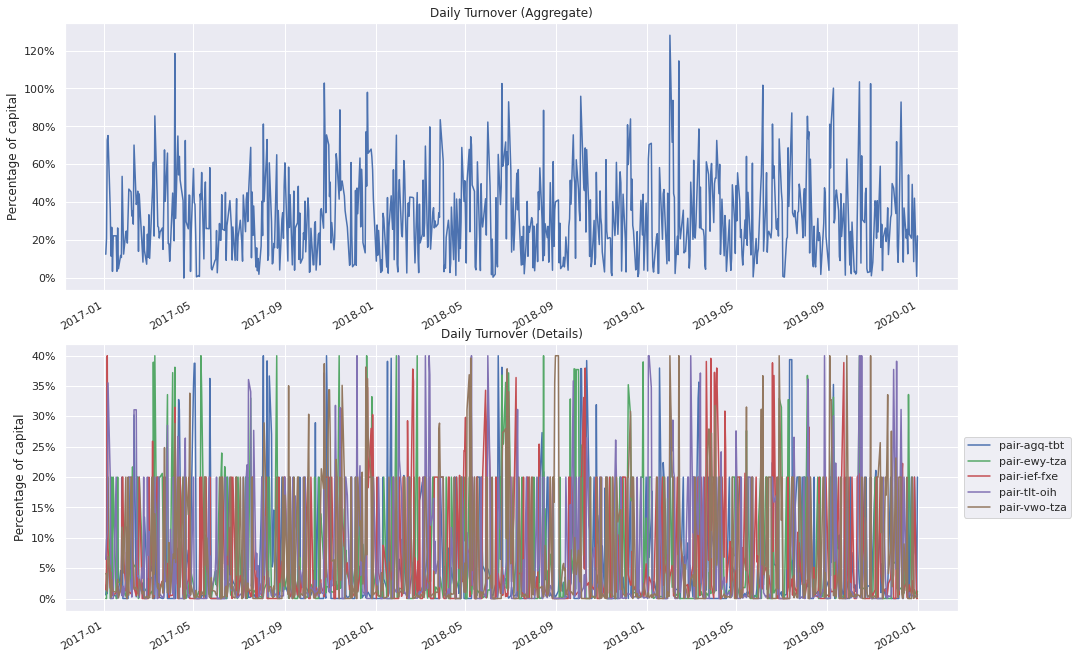

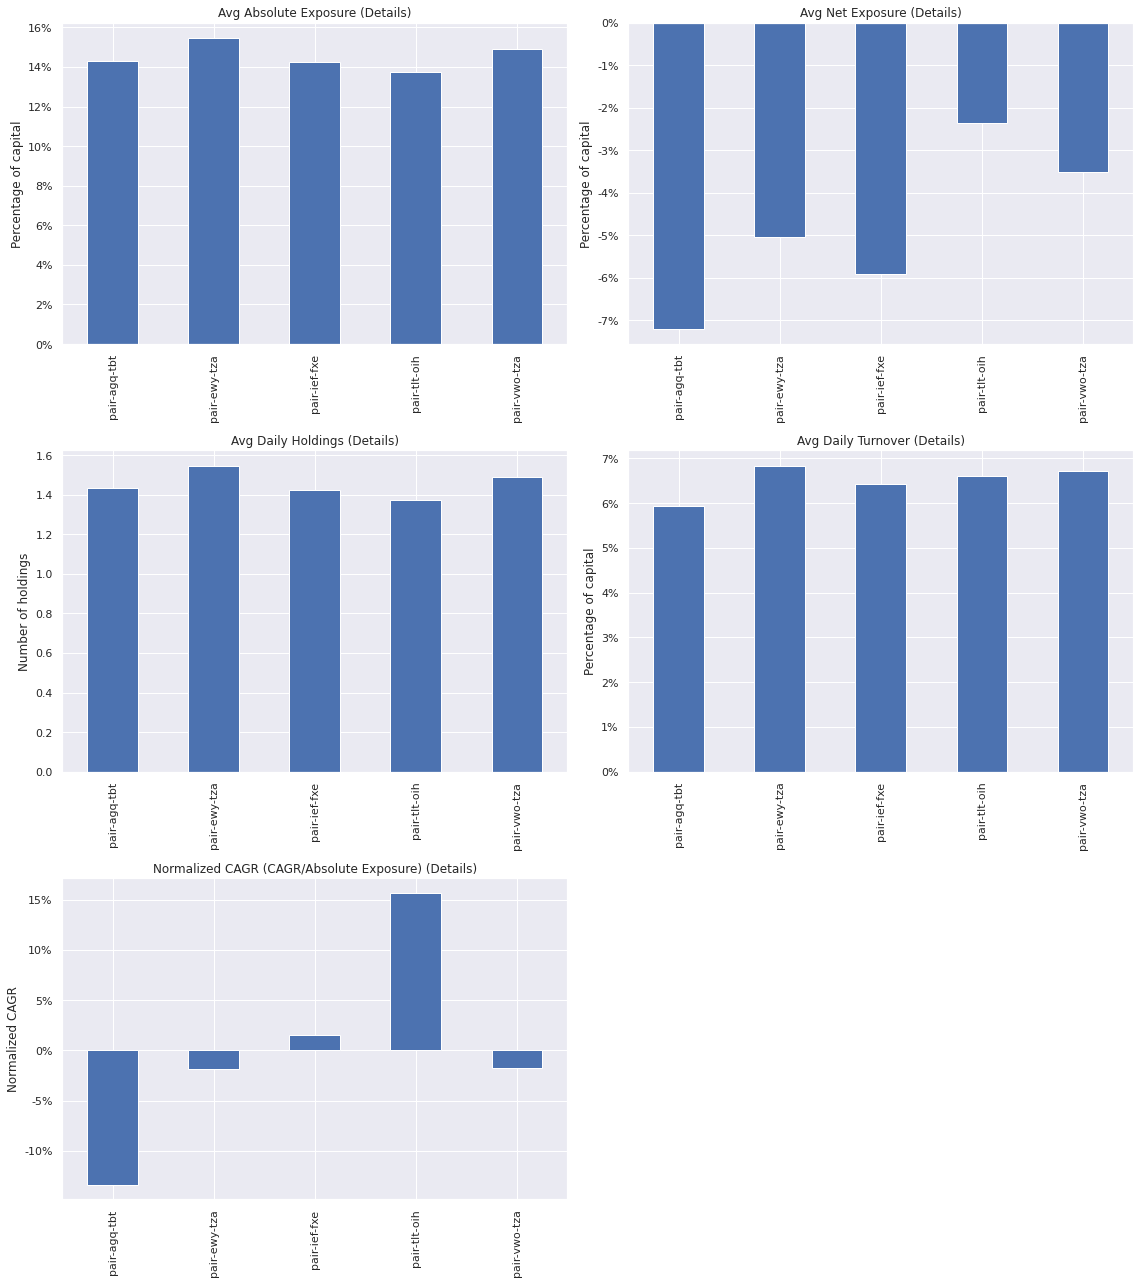

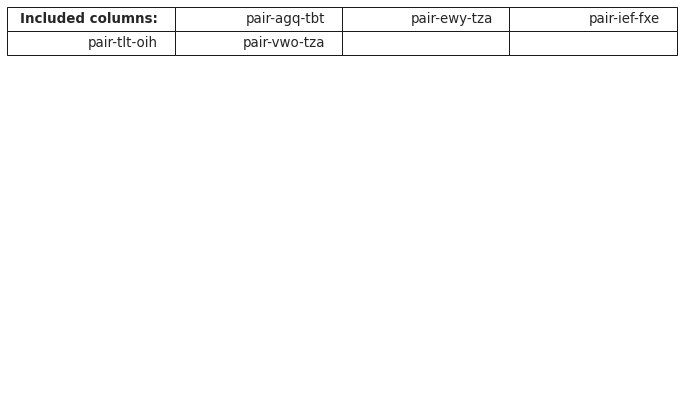

In [11]:
from moonchart import Tearsheet
Tearsheet.from_moonshot_csv("best_pairs_results.csv")

***

[Back to Introduction](Introduction.ipynb)